<a href="https://colab.research.google.com/github/EirikMarquez/SWAT-IDS-Erk/blob/main/Anomaly_3_attacks_25_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series prediction using SWaT dataset
***Outline:***
> The SWaT dataset and how to clean the data

> Extract attacks (Multivariate time series) and present in matplotlib

> Design the model

> Train the model

> Test the model

> Evaluat and save the model




## Problem statement:
Prediction in time series is important to solve the anomaly attacks detection in Industrial Control System (ICS).

In this presentation, we will show one of the algorithms to forecast the graph of the network trafic. We will CNN and RNN to train model to predict the data of three kind of attacks in SWaT dataset.

In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.18.0


In [41]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Secure Water Treatment (SWaT) Dataset

The data collected from the testbed consists of 11 days of continuous operation. 7 days’ worth of data was collected under normal operation while 4 days’ worth of data was collected with attack scenarios.  During the data collection, all network traffic, sensor and actuator data were collected.

For more information about this dataset please see the link:
[SWaT website](https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/)

Attack is on LIT301 - the value is spoofed to 1024 to eventually lead to an underflow.

Attack is from 2019-07-20T07:13:27.0030059Z (row 9598) to 2019-07-20T07:17:47.0050048Z (row 9857)

Normal plant run time for training data is from 2019-07-20T04:33:27.004013Z
 (row 1) to 2019-07-20T06:48:27.004013Z (row 8097)

TRAIN_SPLIT = 8097

Past history we should aim to do 15 minutes (900 seconds): from 2019-07-20T06:48:28.0050048Z (row 8098) to 2019-07-20T07:03:28.004013Z (row 8998)

Future target (total number of predictions): from 2019-07-20T07:03:29.004013Z (row 8999) to 2019-07-20T08:33:27.004013Z
 (row 14397). Will have to complete this in batches.

In [42]:
# # Reading data from google drive
# zip_path = tf.keras.utils.get_file(
#     origin='https://drive.google.com/uc?export=download&id=1klDpUNwhYp_pbUALdpKMbydBTYupIvkH',
#     fname='Attack2.csv.zip',
#     extract=True)
# csv_path, _ = os.path.splitext(zip_path)

# df = pd.read_csv(csv_path)


In [43]:
import pandas as pd
"""
1. Copied original SWAT Dataset
2. Deleted all cell columns before 'AIT-301' and after 'P302 Status'
4. Deleted all rows until GMT Time: '2019-07-20T04:33:27.004013Z'
3. Share spreadhseet document and extract ID
"""
#https://docs.google.com/spreadsheets/d/1jMiiOmooebI5ZenKEp4GCH-1-BN1POZh/edit?usp=sharing&ouid=109890840785241825244&rtpof=true&sd=true
sheet_id = '1jMiiOmooebI5ZenKEp4GCH-1-BN1POZh'
export_url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv'

df = pd.read_csv(export_url)

In [44]:
df.head()

,GMT +0,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status
0,2019-07-20T04:33:27.004013Z,8.550387,269.082520,143.222992,1.210065,0.000512,829.354700,1,1,1,1,99,1,1
1,2019-07-20T04:33:28.0020141Z,8.550387,269.082520,143.222992,1.210065,0.000512,829.835300,1,1,1,1,99,1,1
2,2019-07-20T04:33:29.004013Z,8.550387,269.082520,143.222992,1.210065,0.000512,830.996900,1,1,1,1,99,1,1
3,2019-07-20T04:33:30.0020141Z,8.550387,269.082520,143.222992,1.210065,0.000512,831.197144,1,1,1,1,99,1,1
4,2019-07-20T04:33:31Z,8.550387,269.184967,143.222992,1.210065,0.000512,831.757900,1,1,1,1,99,1,1


In [45]:
TRAIN_SPLIT = 8097
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [46]:
tf.random.set_seed(13)


In [47]:
def create_time_steps(length):
  return list(range(-length, 0))

In [48]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt



```
# This is formatted as code
```

Multivariate Time Series

In [49]:
# Extract 3 kinds of attack
features_considered = ['LIT 301', 'AIT 301', 'AIT 302']

In [50]:
features = df[features_considered]
features.index = df['GMT +0']
print(features.head())

                                 LIT 301   AIT 301     AIT 302
GMT +0                                                        
2019-07-20T04:33:27.004013Z   829.354700  8.550387  269.082520
2019-07-20T04:33:28.0020141Z  829.835300  8.550387  269.082520
2019-07-20T04:33:29.004013Z   830.996900  8.550387  269.082520
2019-07-20T04:33:30.0020141Z  831.197144  8.550387  269.082520
2019-07-20T04:33:31Z          831.757900  8.550387  269.184967


array([<Axes: xlabel='GMT +0'>, <Axes: xlabel='GMT +0'>,
       <Axes: xlabel='GMT +0'>], dtype=object)

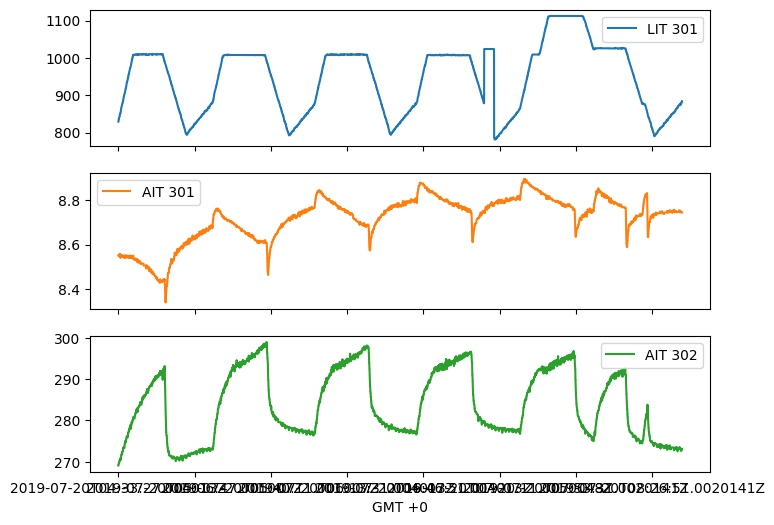

In [51]:
# Draw and show the data over time for 3 attack types
features.plot(subplots=True)

In [52]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [53]:
dataset = (dataset-data_mean)/data_std

In [54]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [55]:
## Plot the training history
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Multistep Model

## Design the model


In [56]:
past_history = 720
future_target = 72
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [57]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target LIT 301 value to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (720, 3)

 Target LIT 301 value to predict : (72,)


In [58]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [59]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

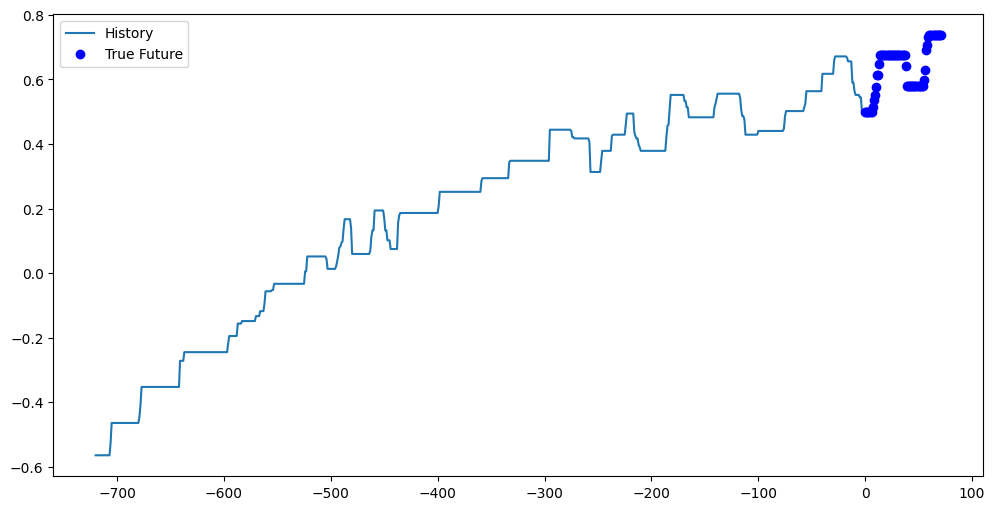

In [60]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [61]:
# Create the deep neural network model
def create_model():
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='tanh',
                         input_shape=x_train_multi.shape[-2:]))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=4))
        model.add(tf.keras.layers.LSTM(64))
        model.add(tf.keras.layers.Dense(units=future_target, activation='tanh'))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

        print(model.summary())
        return model

In [62]:
multi_step_model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 720, 256)            │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 180, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 72)                  │           4,680 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,952 (355.28 KB)

 Trainable params: 90,952 (355.28 KB)

 Non-trainable params: 0 (0.00 B)

None


In [63]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
(256, 72)


In [64]:
log_dir = os.path.join(
    "logs",
    "fit",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS = 5
EVALUATION_INTERVAL = 200

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[tensorboard_callback])

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.0195 - loss: 0.3450 - val_accuracy: 0.0162 - val_loss: 0.1271
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.0192 - loss: 0.1439 - val_accuracy: 0.0128 - val_loss: 0.1302
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.0236 - loss: 0.1394 - val_accuracy: 0.0407 - val_loss: 0.1277
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.0335 - loss: 0.1371 - val_accuracy: 0.0233 - val_loss: 0.1242
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.0371 - loss: 0.1356 - val_accuracy: 0.0142 - val_loss: 0.1286


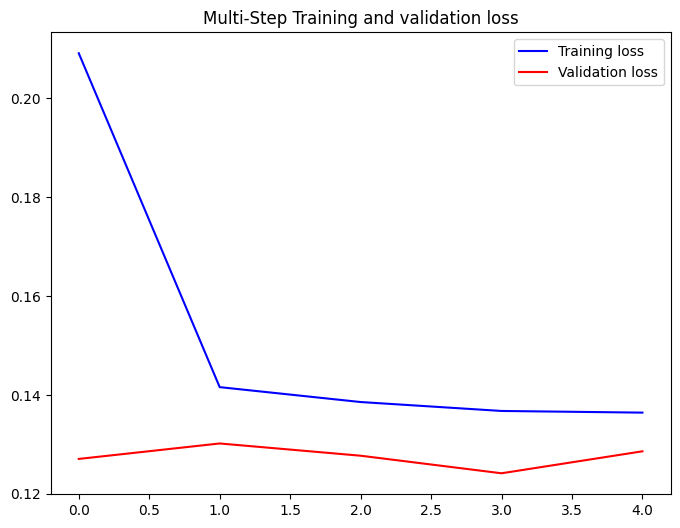

In [65]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


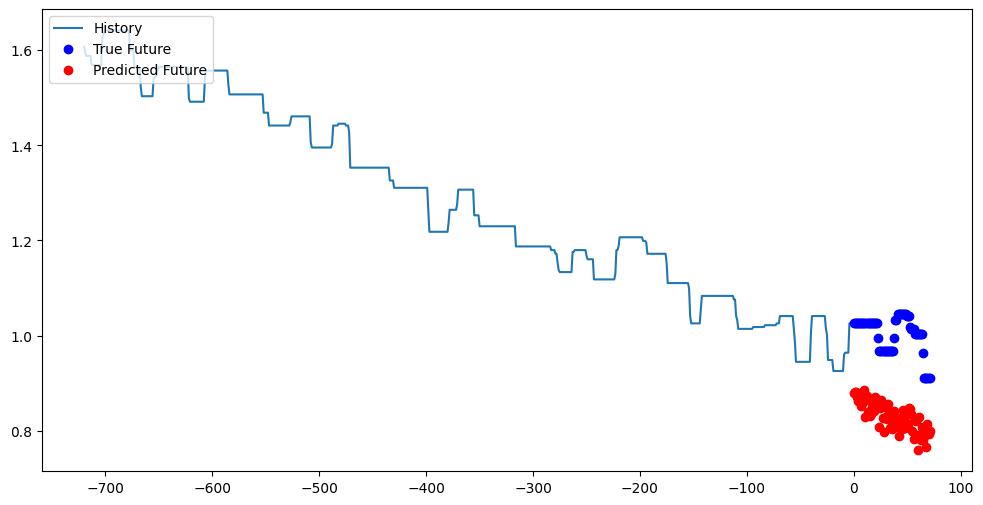

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


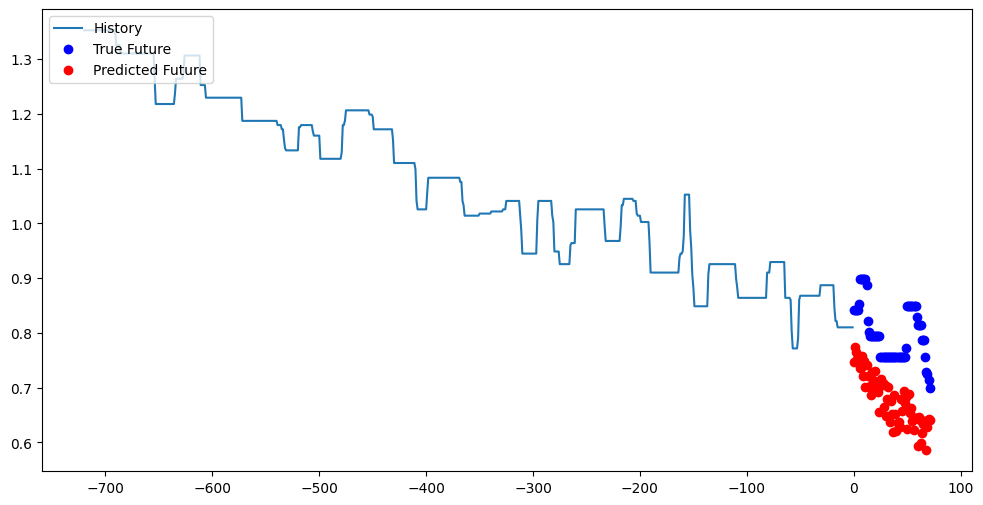

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


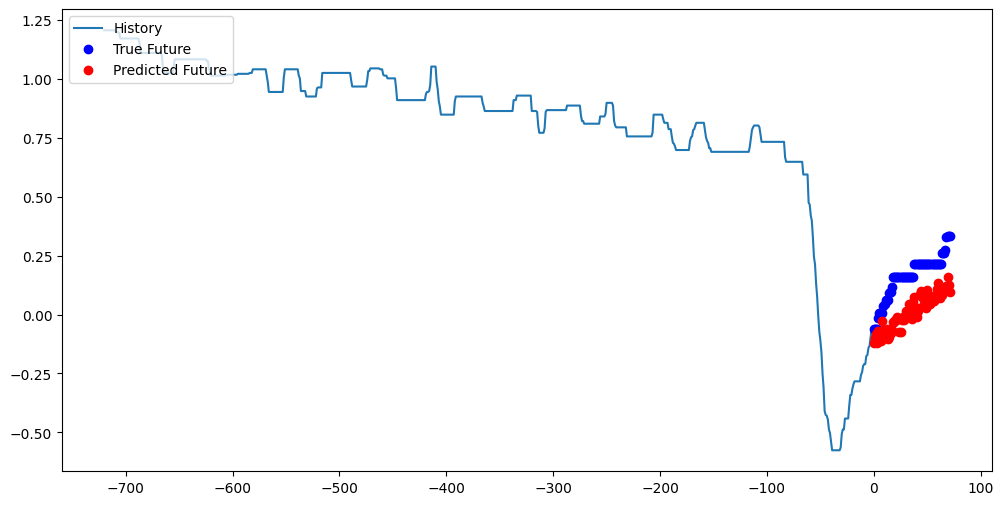

In [66]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [67]:
# Saving the model to reuse
multi_step_model.save('model_attack2.h5')